## Comparing pyfm2d and pykonal on a constant velocity model in cartesian coordinates

Pykonal is an implementation of the fast marching method available here [https://github.com/malcolmw/pykonal](https://github.com/malcolmw/pykonal) and here we compare `pyfm2d` with `pykonal` for the cartesian 2d example example given here [https://malcolmw.github.io/pykonal-docs/examples.html](https://malcolmw.github.io/pykonal-docs/examples.html)

Some observations...
- Source grid refinement and resampling of the velocity model  are turned on by default in `pyfm2d`. While they increase computation time the resulting travel times are more accurate when compared with `pykonal` for a constant velocity model.
- If we turn source grid refinement and resampling of the velocity model off in `pyfm2d` the numerical errors are comparable to `pykonal` with the execution time for `pyfm2d` being lower by a factor of $\approx$ 25% when compard to `pykonal`.
- `pyfm2d` is compiled with the `-fbounds-check` and `-fbacktrace ` flag changing them to `-O3` is might improve its performance further.


In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyfm2d
import time

In [6]:
# This noteboook requires pykonal which can be installed by uncommenting the next line that is remove the #
#!pip install pykonal

In [7]:
# setup the problem size
nx=80
ny=80

## pykonal

In [8]:
# Import modules.
import numpy as np
import pykonal

# Instantiate EikonalSolver object using Cartesian coordinates.
solver = pykonal.EikonalSolver(coord_sys="cartesian")
# Set the coordinates of the lower bounds of the computational grid.
# For Cartesian coordinates this is x_min, y_min, z_min.
# In this example, the origin is the lower bound of the computation grid.
solver.velocity.min_coords = 0, 0, 0
# Set the interval between nodes of the computational grid.
# For Cartesian coordinates this is dx, dy, dz.
# In this example the nodes are separated by 1 km in in each direction.
solver.velocity.node_intervals = 1, 1, 1
# Set the number of nodes in the computational grid.
# For Cartesian coordinates this is nx, ny, nz.
# This is a 2D example, so we only want one node in the z direction.
solver.velocity.npts = nx, ny, 1
# Set the velocity model.
# In this case the velocity is equale to 1 km/s everywhere.
solver.velocity.values = np.ones(solver.velocity.npts)

# Initialize the source. This is the trickiest part of the example.
# The source coincides with the node at index (0, 0, 0)
src_idx = 0, 0, 0
# Set the traveltime at the source node to 0.
solver.traveltime.values[src_idx] = 0
# Set the unknown flag for the source node to False.
# This is an FMM state variable indicating which values are completely
# unknown. Setting it to False indicates that the node has a tentative value
# assigned to it. In this case, the tentative value happens to be the true,
# final value.
solver.unknown[src_idx] = False
# Push the index of the source node onto the narrow-band heap.
solver.trial.push(*src_idx)
# Solve the system.
solver.solve()
# And finally, get the traveltime values.
ttpykonal=solver.traveltime.values[:,:,0]

# pyfm2d

In [9]:
extent = [0.0, nx, 0.0, ny]
m = solver.velocity.values[:,:,0]
g = pyfm2d.BasisModel(m, extent=extent)

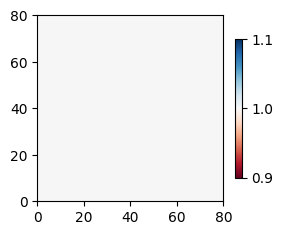

In [10]:
velocity = g.get_velocity()
pyfm2d.display_model(velocity, extent=extent, figsize=(3, 3), clim=(0.9, 1.1))

In [11]:
srcs=np.array([0,0])
recs=[]
for i in range(nx):
    for j in range(ny):
        recs.append([i,j])
recs=np.array(recs)

In [12]:
# run wave front tracker
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=False,
    paths=False,
    cartesian=True,
    sourcedicelevel=1,
    sourcegridsize=1,
    dicex=1,
    dicey=1
)
start_time = time.perf_counter()
result = pyfm2d.calc_wavefronts(velocity, recs, srcs, extent=extent, options=options)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"\nThe command took {elapsed_time:.4f} seconds to execute.")

ttpyfm2d=result.ttimes


The command took 0.0019 seconds to execute.


## Analytical solution 

In the following we plot the difference between the solution computed by `pykonal` respectively `pyfm2d` and the analyticla solution for constant velcoity model defined in cartesian coordinates.

In [13]:
import matplotlib.pyplot as plt 
ttconst=np.zeros([nx,ny])
for i in range(nx):
    for j in range(ny):
        ttconst[i,j]=np.sqrt((float(i)**2+float(j)**2))

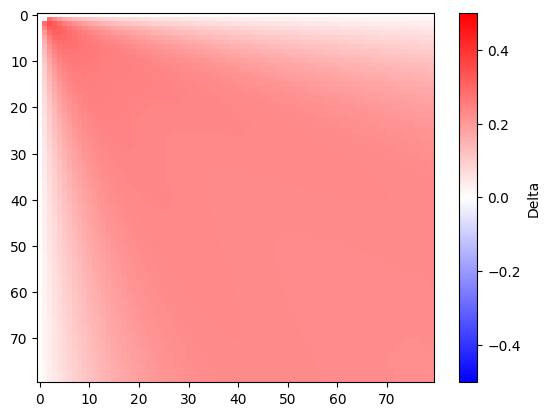

In [14]:
# difference for pyfm2d
plt.plot()
plt.imshow(ttpyfm2d.reshape(nx,ny)-ttconst, cmap='bwr', aspect='auto',clim=(-0.5, 0.5),) 
plt.colorbar(label='Delta')

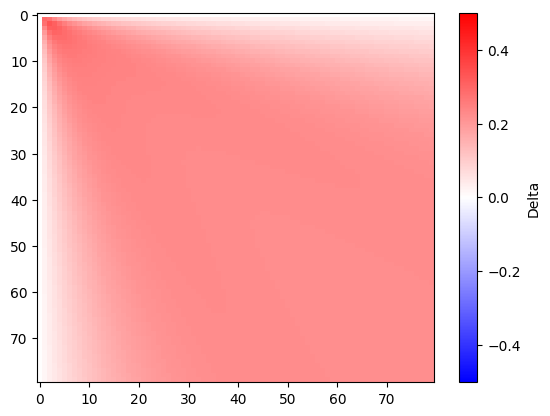

In [15]:
# difference for pykonal
plt.plot()
plt.imshow(ttpykonal-ttconst, cmap='bwr', aspect='auto',clim=(-0.5, 0.5)) 
plt.colorbar(label='Delta')

# Compare the execution time for 1000 runs

In [16]:

start_time = time.perf_counter()
for i in range(1000):
    options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=False,
    paths=False,
    cartesian=True,
    sourcedicelevel=1,
    sourcegridsize=1,
    dicex=1,
    dicey=1
    )
    result = pyfm2d.calc_wavefronts(velocity, recs, srcs, extent=extent, options=options)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"\n pyfm2d took {elapsed_time:.4f} seconds to execute.")


 pyfm2d took 1.0888 seconds to execute.


In [17]:
start_time = time.perf_counter()
for i in range(1000):
    solver = pykonal.EikonalSolver(coord_sys="cartesian")
    solver.velocity.min_coords = 0, 0, 0
    solver.velocity.node_intervals = 1, 1, 1
    solver.velocity.npts = nx, ny, 1
    solver.velocity.values = np.ones(solver.velocity.npts)
    src_idx = 0, 0, 0
    solver.traveltime.values[src_idx] = 0
    solver.unknown[src_idx] = False
    solver.trial.push(*src_idx)
    solver.solve()
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"\npykonal took {elapsed_time:.4f} seconds to execute.")


pykonal took 1.5799 seconds to execute.
